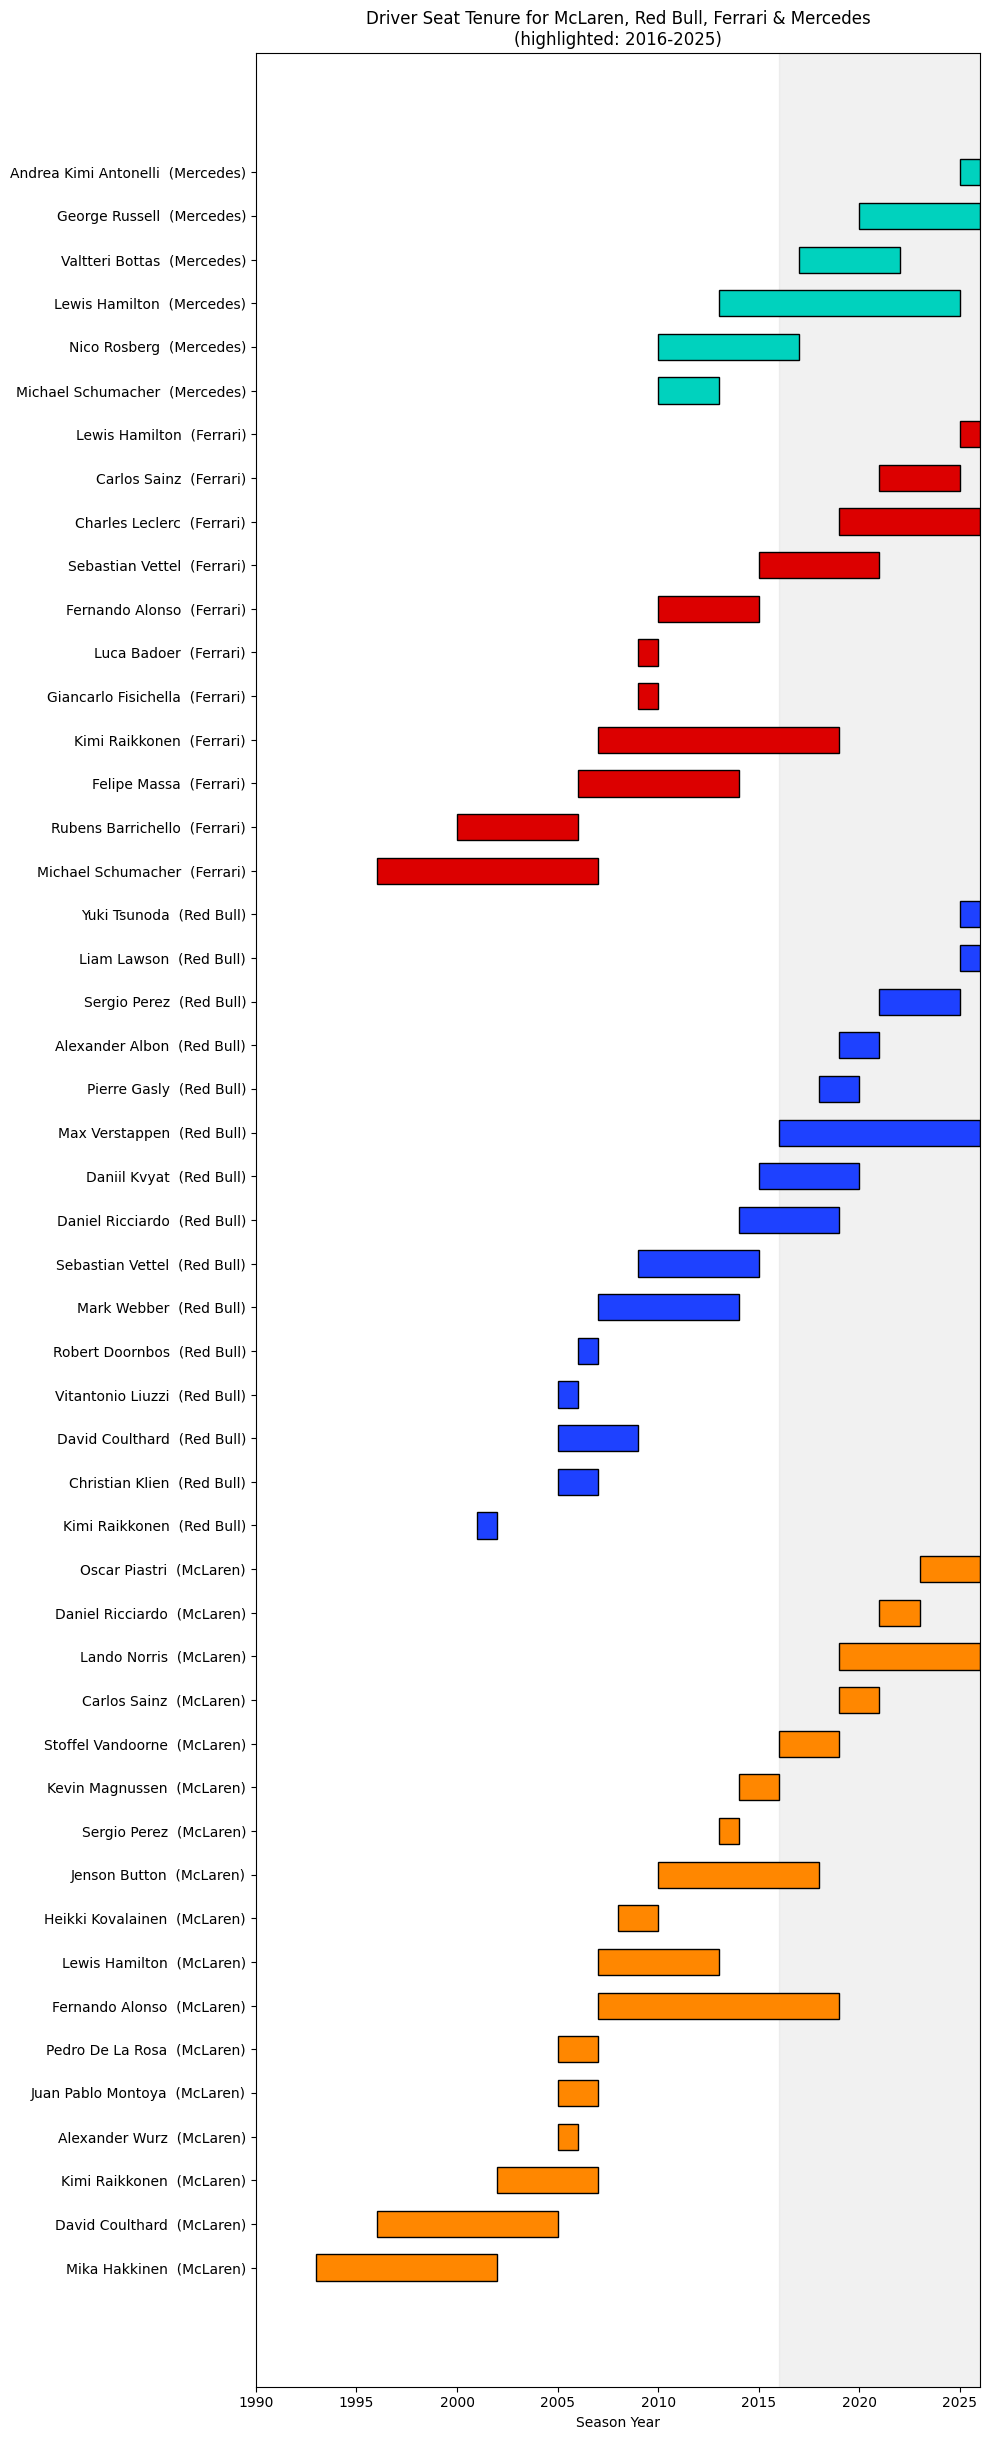

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("allDriversHistorical.csv")

core_teams = ['McLaren', 'Red Bull', 'Ferrari', 'Mercedes']
mask = df['Team'].str.contains('|'.join(core_teams), case=False, na=False)
df_filt = df[mask].copy()
def core_from_name(full_name):
    for core in core_teams:
        if core.lower() in full_name.lower():
            return core
    return 'Other'

df_filt['CoreTeam'] = df_filt['Team'].apply(core_from_name)
spans = (
    df_filt
    .groupby(['Driver','CoreTeam'])['Year']
    .agg(start='min', end='max')
    .reset_index()
)
team_order = {team: i for i, team in enumerate(core_teams)}
spans['TeamOrder'] = spans['CoreTeam'].map(team_order)
spans = spans.sort_values(['TeamOrder', 'start', 'Driver']).reset_index(drop=True)
colors = {
    'McLaren':   '#FF8700',
    'Red Bull':  '#1E41FF',
    'Ferrari':   '#DC0000',
    'Mercedes':  '#00D2BE'
}
fig, ax = plt.subplots(figsize=(10, 0.5 * len(spans)))
ax.axvspan(2016, 2026, color='lightgrey', alpha=0.3, zorder=0)

for idx, row in spans.iterrows():
    ax.barh(
        y=idx,
        width = row['end'] - row['start'] + 1,
        left  = row['start'],
        height=0.6,
        color = colors[row['CoreTeam']],
        edgecolor='black',
        zorder=1
    )
ax.set_yticks(range(len(spans)))
ax.set_yticklabels(spans['Driver'] + '  (' + spans['CoreTeam'] + ')')
min_year, max_year = df['Year'].min(), df['Year'].max()
ax.set_xlim(min_year - 1, max_year + 1)
ax.set_xlabel('Season Year')
ax.set_title('Driver Seat Tenure for McLaren, Red Bull, Ferrari & Mercedes\n(highlighted: 2016-2025)')
plt.tight_layout()
plt.show()


In [ ]:

tenure_df = df[['Driver','Team','Year']].drop_duplicates().copy()
stints = (
    tenure_df
    .groupby(['Driver','Team'])['Year']
    .agg(start='min', end='max')
    .reset_index()
)
stints['tenure_seasons'] = stints['end'] - stints['start'] + 1

team_keywords = ['Red Bull','Mercedes','Ferrari','McLaren']
pattern = '|'.join(team_keywords)
sub = stints[stints['Team'].str.contains(pattern, case=False, na=False)].copy()

rb_seasons    = sub.loc[sub['Team'].str.contains('Red Bull', case=False, na=False),
                        'tenure_seasons'].values
other_seasons = sub.loc[~sub['Team'].str.contains('Red Bull', case=False, na=False),
                        'tenure_seasons'].values

print(f"Red Bull stints: {len(rb_seasons)}, mean={rb_seasons.mean():.1f} seasons")
print(f"Other teams:   {len(other_seasons)}, mean={other_seasons.mean():.1f} seasons")




Red Bull stints: 27, mean=1.9 seasons
Other teams:   63, mean=2.6 seasons


In [ ]:

import numpy as np
from scipy.stats import gamma
alpha0, beta0 = 1.0, 1.0

n_rb,  sum_rb    = rb_seasons.size,    rb_seasons.sum()
n_oth, sum_oth   = other_seasons.size, other_seasons.sum()

alpha_rb,  beta_rb  = alpha0 + n_rb,  beta0 + sum_rb
alpha_oth, beta_oth = alpha0 + n_oth, beta0 + sum_oth
nsamps   = 5000
lam_rb   = gamma.rvs(a=alpha_rb,  scale=1/beta_rb,  size=nsamps)
lam_oth  = gamma.rvs(a=alpha_oth, scale=1/beta_oth, size=nsamps)
mu_rb_samps  = 1 / lam_rb
mu_oth_samps = 1 / lam_oth

print("Posterior mean tenure (seasons):")
print(f"  Red Bull: {mu_rb_samps.mean():.2f}  "
      f"(95% CI [{np.percentile(mu_rb_samps, 2.5):.2f}, {np.percentile(mu_rb_samps, 97.5):.2f}])")
print(f"  Others  : {mu_oth_samps.mean():.2f}  "
      f"(95% CI [{np.percentile(mu_oth_samps, 2.5):.2f}, {np.percentile(mu_oth_samps, 97.5):.2f}])")

p_shorter = np.mean(mu_rb_samps < mu_oth_samps)
print(f"P(Red Bull mean tenure < other teams) = {p_shorter:.3f}")


Posterior mean tenure (seasons):
  Red Bull: 1.96  (95% CI [1.35, 2.83])
  Others  : 2.62  (95% CI [2.04, 3.35])
P(Red Bull mean tenure < other teams) = 0.905


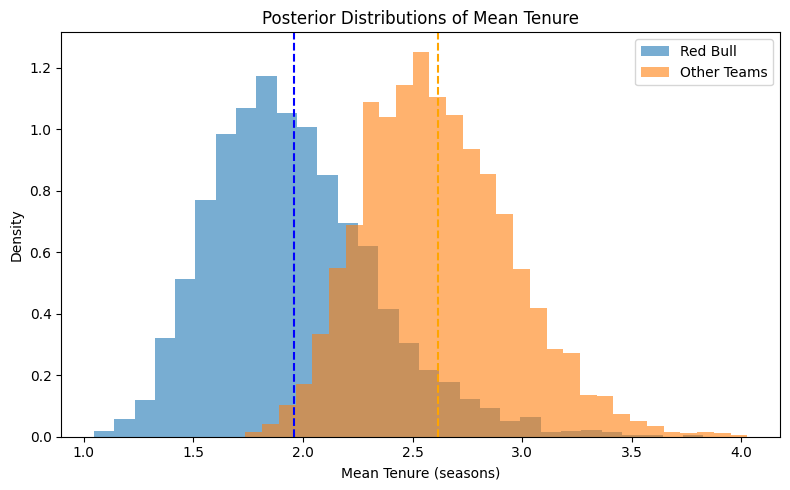

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(mu_rb_samps,  bins=30, density=True, alpha=0.6, label='Red Bull')
plt.hist(mu_oth_samps, bins=30, density=True, alpha=0.6, label='Other Teams')
plt.axvline(mu_rb_samps.mean(),  color='blue',  linestyle='--')
plt.axvline(mu_oth_samps.mean(), color='orange',linestyle='--')
plt.xlabel('Mean Tenure (seasons)')
plt.ylabel('Density')
plt.title('Posterior Distributions of Mean Tenure')
plt.legend()
plt.tight_layout()
plt.show()


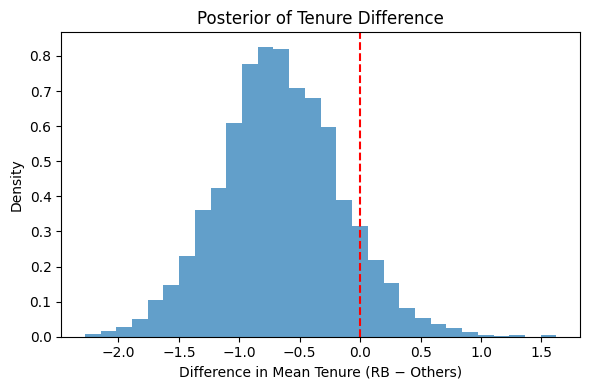

In [ ]:

plt.figure(figsize=(6,4))
diff = mu_rb_samps - mu_oth_samps
plt.hist(diff, bins=30, density=True, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Difference in Mean Tenure (RB − Others)')
plt.ylabel('Density')
plt.title('Posterior of Tenure Difference')
plt.tight_layout()
plt.show()
